# Numerical methods


SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.

Available sub-packages include:

- `constants`: physical constants and conversion factors
- `optimize`: optimization algorithms including linear programming (this lecture)
- `interpolate`: interpolation tools (next lecture)
- `stats`: statistical functions (next lectures)
- `integrate`: numerical integration routines (this lecture)
- `fft`: Discrete Fourier Transform algorithms (this lecture)
- `fftpack`: Legacy interface for Discrete Fourier Transforms (this lecture)
- `linalg`: linear algebra routines (previous lecture)
- `sparse`: sparse matrices and related algorithms
- and many others

Before implementing a routine, it is worth checking if the desired algorithm is not already implemented in `scipy`. As non-professional programmers, scientists often tend to re-invent the wheel, which leads to buggy, non-optimal, difficult-to-share and unmaintainable code. By contrast, `scipy`'s routines are optimized and tested, and should therefore be used when possible.

##  Roots of functions

There are several root finding algorithms for a generic function $f(x): {\rm I\!R} \to {\rm I\!R}$, e.g. [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or Brent (a safer version of the secant method, which combines a bracketing strategy with a parabolic approximation).

Interestingly, the `scipy.optimize` module provides several algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

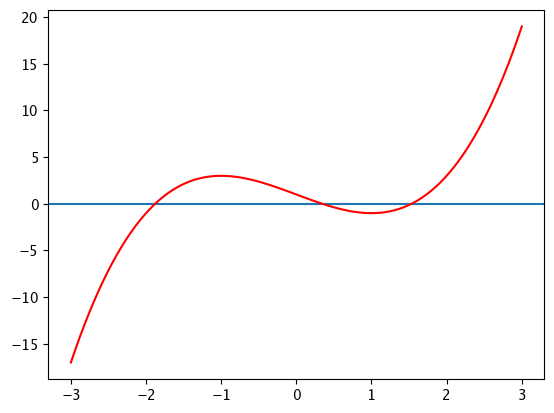

In [2]:
def f(x):
    return x**3 - 3*x + 1

x = np.linspace(-3, 3, 100)
plt.axhline(0)
plt.plot(x, f(x),'r-')

You can see that the results may depend on the starting point:

In [3]:
from scipy.optimize import newton
# The Newton method just needs the initial point
x1, x2, x3 = newton(f, -3), newton(f, 0), newton(f, 3)
print(x1, x2, x3)

-1.8793852415718166 0.34729635533385395 1.5320888862379578


In [4]:
%timeit newton(f, 0)

303 µs ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Let's try now the [Brentq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) module from ScipPy:

In [5]:
from scipy.optimize import brentq
# Specifying the function and the range to look for zeroes is mandatory
x1, x2, x3 = brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)
print(x1, x2, x3)

-1.8793852415718166 0.3472963553337031 1.532088886237956


In [6]:
%timeit brentq(f, 0, 1)

7.12 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


As you can verify, two independent methods yield the same result, but the performance can be very different, as every algorithm has its pros and cons.

### Multi-dimensional functions

In case of $f(x): {\rm I\!R}^2 \to {\rm I\!R}$, the `optimize.root` is available, also implementing several methods (MINPACK's hybrid being the default).

MINPACK-1 is a package of Fortran subprograms for the numerical solution of systems of nonlinear equations and nonlinear least squares problems. [Link to the documentation (warning, 261 pages!)](https://cds.cern.ch/record/126569/files/CM-P00068642.pdf)

Of course, MINPACK can be used also in one dimension, or in any case where an accurate and reliable numerical method is required.

When performing complex root finding and minimizations, always **check if the algorithm has converged!**

In [7]:
def f(x):
    return [x[1] - 3*x[0]*(x[0] + 1)*(x[0] - 1), 0.25*x[0]**2 + x[1]**2 - 1]

solutions = optimize.root(f, (0.5, 0.5))
# optimize.root returns an object which contains the result of the root finding
print(solutions)

print("\n\nSolution:\nx0 =", solutions['x'], "\nf(x0) =", f(solutions['x']))

    fjac: array([[-0.99782686,  0.06589046],
       [-0.06589046, -0.99782686]])
     fun: array([-1.63602465e-12,  1.61870517e-12])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-1.49465503e-08,  1.27017698e-08])
       r: array([ 8.22949362, -0.88256935, -1.72647892])
  status: 1
 success: True
       x: array([1.11694147, 0.82952422])


Solution:
x0 = [1.11694147 0.82952422] 
f(x0) = [-1.6360246490876307e-12, 1.6187051699034782e-12]


## Minimization of a function

In general, minimization of $f(x): {\rm I\!R}^n \to {\rm I\!R}$ is a whole field of study per se. You should have seen it treated in details in other courses.

In the example below, we see an example of how SciPy can perform the numerical minimization of a function.
The `minimize_scalar` function will find the minimum, and a search interval can be specified. By default, it uses the Brent algorithm.

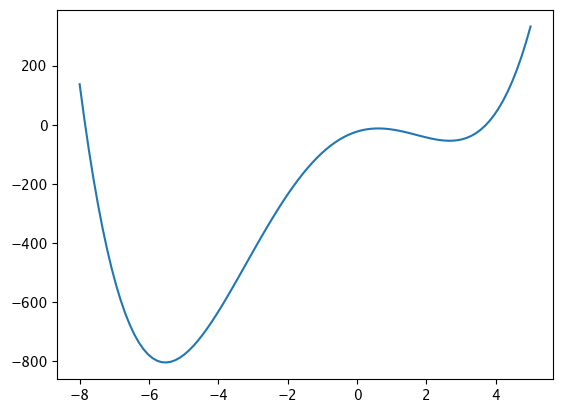

In [8]:
def f(x):
    return x**4 + 3*(x - 2)**3 - 15*x**2 + 1

x = np.linspace(-8, 5, 100)
plt.plot(x, f(x))

In [9]:
solution = optimize.minimize_scalar(f, method='Brent')
print(solution)

     fun: -803.3955308825884
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663


The output provides more information than the result alone:

- `nfev` is the number of function evaluations
- `nit` is the number of iterations of the algorithm
- `success` is the status

Pay attention than different ranges or even different algorithms may yield different results:

In [10]:
solution = optimize.minimize_scalar(f, method='bounded', bounds=[0, 6])
print(solution) # different algorithms return different objects

     fun: -54.21003937712762
 message: 'Solution found.'
    nfev: 12
     nit: 12
  status: 0
 success: True
       x: 2.668865104039653


### Local and global minima

If the function is not trivial (and especially if it is in higher dimensions than 1), it may contain several minima. In these cases, care has to be taken to specify a good starting point, otherwise the algorithm will converge in a local (false) minimum.

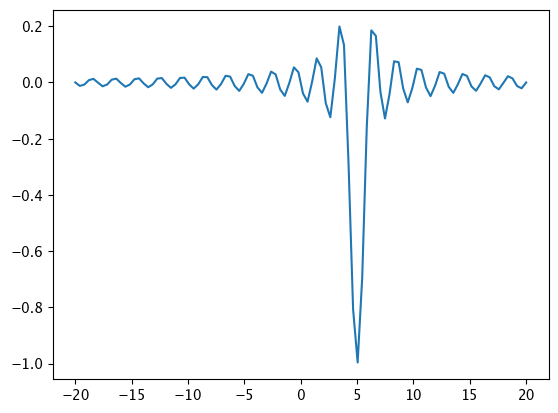

In [11]:
def f(x, offset):
    return -np.sinc(x - offset)

x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5))

     fun: -0.049029624014074166
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 15
     nit: 10
 success: True
       x: -1.4843871263953001


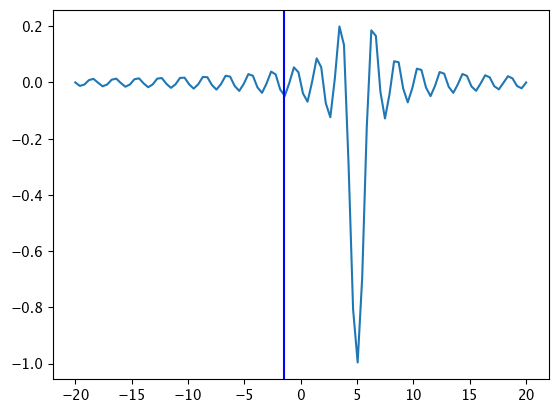

In [12]:
# note how additional function arguments are passed in
solution = optimize.minimize_scalar(f, args=(5,))
print(solution)

plt.plot(x, f(x, 5))
plt.axvline(solution['x'], color='b')

Optimization results are packed accordingly to this [format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult).

When the function oscillates a lot, often the global minimum is not found. To cope with that, several ranges needs to be explored. This can be done either manually...

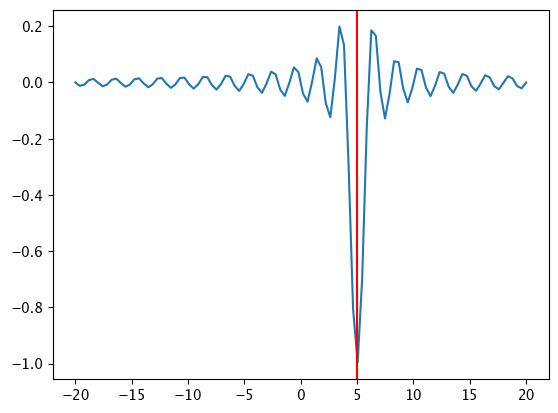

In [13]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
solutions = [optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]
# split the x range in intervals, and run minimize_scalar in each one, then pick the interval with the smallest minimum
idx = np.argmin([solution['fun'] for solution in solutions])
solution = solutions[idx]

plt.plot(x, f(x, 5))
plt.axvline(solution['x'], color='r')

...or using dedicated methods, like the [basinhopping](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html), which are specifically designed to overcome these issues:

In [14]:
from scipy.optimize import basinhopping

x0 = 10
solution = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)}) # see how the parameters are passed to the function
print(solution)

                        fun: -1.0
 lowest_optimization_result:       fun: -1.0
 hess_inv: array([[0.30396368]])
      jac: array([7.4505806e-09])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([4.99999999])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1136
                        nit: 100
                       njev: 568
                    success: True
                          x: array([4.99999999])


In [ ]:
plt.plot(x, f(x, 5))
plt.axvline(solution['x'], color='r')

It's very likely that an algorithm that solves your problem has already been implemented: in this case, it's always more efficient to use the dedicated library.

# Numerical integration

Numerical integration, also called quadrature (especially in one-dimension), adresses the basic problem in numerical integration to compute an approximate solution to a definite integral $\int_a^b f(x) dx$ to a given degree of accuracy.

$f(x)$ should be a smooth function integrated over a small number of dimensions, and the domain of integration should be bounded.

There are many methods for approximating the integral to the desired precision, which potentially require one whole course per se, which are implemented in the `scipy.integrate` Pythion library. In the following examples, we will see the application of the `integrate` library to solve some common cases.

The most generic integration routine is `scipy.integrate.quad()`, which integrate a one-dimensional function from $a$ to $b$ using a technique (check the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)) from the Fortran library QUADPACK.

In this example, we compute the integral of a simple function $\int_0^{\pi/2} \sin{\theta}d\theta$, whose result is known analytically (and is 1):

In [15]:
from scipy.integrate import quad, quadrature

# call quad and pass the function, the min and max of the integration interval
# note that the function must be numpy-compliant, e.g. vectorized
# in other words, only numpy functions (np.cos, ...) and vectorized operations (+, -, *, **, ...) are allowed
res, err = quad(np.sin, 0, np.pi/2)

# an alternative method is the gaussian quadrature, but the uncertainty is larger
#res, err = quadrature(np.sin, 0, np.pi/2)

print("Integral:", res, "+-", err)
print(np.allclose(res, 1)) # np.allclose() checks that two numpy arrays have all close values

Integral: 0.9999999999999999 +- 1.1102230246251564e-14
True


Another example of integration of a not-so-simple function:

Integral: 16.315541717155426 +- 5.6158704353492794e-09


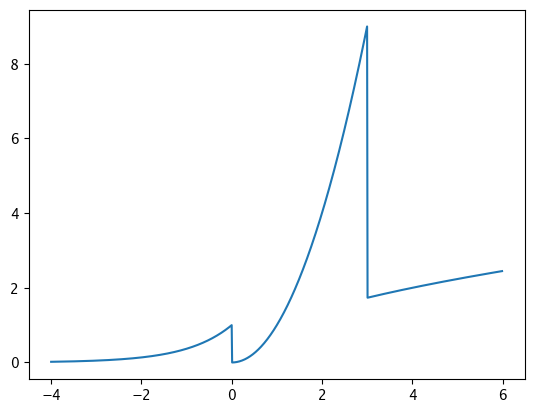

In [16]:
def conditional_function(x):
    if x < 0:
        return np.exp(x)
    if x < 3:
        return x**2
    if x == 3:
        return 0
    if x > 3:
        return np.sqrt(x)
    if x >= 5:
        return np.exp(-x)
    
# this Numpy method converts the regular function into a Numpy function
np_conditional_function = np.vectorize(conditional_function)

res, err = quad(np_conditional_function, -4, 6) #Integrate it from -4 to 6 using the numpy version
print("Integral:", res, "+-", err)

x = np.arange(-4, 6, 0.01)
plt.plot(x, np_conditional_function(x))
plt.show()

A more generic function, but less user-friendly, that extends `quad` to multiple dimensions is `nquad` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html)):

In [17]:
from scipy.integrate import nquad

# define functions as lambda
func = lambda x0, x1, x2, x3 : x0**2 + x1*x2 - x3**3 + np.sin(x0) + (1 if (x0 - .2*x3 - .5 - .25*x1 > 0) else 0)

# define integration points
points = [[lambda x1, x2, x3 : 0.2*x3 + 0.5 + 0.25*x1], [], [], []]

# define optional parameters
def opts0(*args, **kwargs):
    return {'points' : [0.2*args[2] + 0.5 + 0.25*args[0]]} 

# arguments are: function, ranges, options
result, abserr, out = nquad(func, [[0,1], [-1,1], [.13,.8], [-.15,1]], opts=[opts0,{},{},{}], full_output=True)

print("Integral:", result, "+-", abserr)
print(out)

Integral: 1.5267454070738635 +- 2.943736000140233e-14
{'neval': 388962}


## Integrating Ordinary Differential Equations

The Python `scipy.integrate` library also features routines for integrating Ordinary Differential Equations (ODE). It cannot handle coupled (PDEs) or boundary problems. For those and all other things not in Scipy, see this list of other [numerical methods](https://projects.scipy.org/topical-software.html).

To solve an ODE in Python (and all other programming languages/packages):

 - Convert to standard form
 - Implement the standardized equation as a Python function
 - Create a grid of points where you want to evaluate the ODE
 - Call `scipy.integrate.odeint()` passing the function, initial value, and grid ([link to the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html))
 
Specifically, `odeint()` solves ODE of the form:

$$\frac{dy}{dt} = f(t, y_1(t), y_2(t), ...)$$

All first order, second order and n-th order ODEs can be converted into this form. Let's see some examples.


### First order ODEs

 - $\frac{dC(t)}{dt}=−rC(t)$ (chemical reaction)
 - $R\frac{di(t)}{dt} + \frac{i(t)}{C} = 0$ (RC circuits)
 - $L\frac{di(t)}{dt} + R i(t) = V$ (RL circuits)
 
These three examples are a 1-st order ODE, already in standard form or that can be expressed in the standard form with trivial operations.


#### Example: generic first order ODE

As an example, let us solve the ODE:

$$\frac{dy}{dt} = -2 y$$

between $t = 0 \dots 4$, with the initial condition $y(t=0) = 1$:

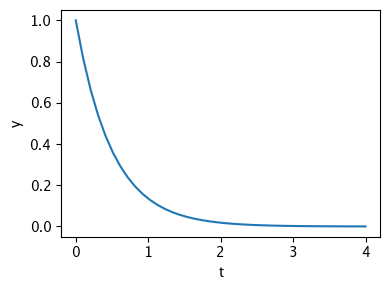

In [31]:
from scipy.integrate import odeint

# first the function computing the derivative of the position needs to be defined
def derivative(ypos, time):
    return -2 * ypos

# define the interval
time_vec = np.linspace(0, 4, 40)

# call the odeint() method
y = odeint(derivative, y0=1, t=time_vec)

# plot the function
plt.figure(figsize=(4, 3))
plt.plot(time_vec, y)
plt.xlabel('t')
plt.ylabel('y')
plt.tight_layout()

### Second order ODEs

- $L\frac{d^2 i(t)}{dt^2} + R\frac{di(t)}{dt} + \frac{1}{C}i(t) = 0$ (RLC circuit)
- $\frac{d^2 x(t)}{dt^2} + k x(t) = 0$ (non-damped mass-spring oscillation)
- $\frac{d^2 x(t)}{dt^2} + 2 \varepsilon \omega_0  \frac{dx(t)}{dt} + \omega_0^2 x(t) = 0$ (mass-spring damped oscillation)

The "trick" for the 2-nd order ODEs is to create a second dimension, the dimensions of the derivative, which turns the problem into a 2D 1-st order ODE.

#### Example: the mass-spring system

In the case of the non-damped spring mass system, we'll use a $x_1(t)=x(t)$ and $x_2(t)=\frac{dx(t)}{dt}$.
So the equation becomes:

$$\frac{d x_2(t)}{dt} + k x_1 (t) = 0$$
and thus
$$\frac{d x_2(t)}{dt} = - k x_1 (t)$$
$$\frac{d x_1(t)}{dt} = x_2(t)$$
Now we have two dimensions and their ODEs are both in standard form.

#### Example: the damped mass-spring system

Let's see a solution for the damped spring mass system.
The position of a mass attached to a spring obeys the 2-nd order ODE reported above, with $\omega_0^2 = k/m$ with $k$ the spring constant, $m$ the mass and $\varepsilon = c/(2 m \omega_0)$ with $c$ the damping coefficient.

In [19]:
# set the constants
mass = 0.5  # kg
kspring = 4  # N/m
cviscous = 0.4  # N s/m

# and thus
eps = cviscous / (2 * mass * np.sqrt(kspring/mass))
omega = np.sqrt(kspring / mass)

The 2-nd order equation needs to be transformed in a system of two first-order equations for the vector $X = (x_1, x_2)$. This can be done by exploiting 2D Numpy arrays. The function computes the velocity and acceleration. In this case, the two 1-st order ODEs are:

$$\frac{d x_1(t)}{dt} = x_2(t)$$
$$\frac{d x_2(t)}{dt} = - \varepsilon \omega_0 x_1 (t) - \omega_0^2 x_2(t)$$

In [32]:
def derivative(X, time, eps, omega):
    return(X[1], -eps * omega * X[1] - omega**2 * X[0])

t = np.linspace(0, 10, 100)
Xinit = (1, 0)
X = odeint(derivative, Xinit, t, args=(eps, omega))

# plot y and y'
plt.figure(figsize=(8, 6))
plt.plot(t, X[:, 0], label="$x_1$")
plt.plot(t, X[:, 1], label="$x_2$")
plt.xlabel('t')
plt.ylabel('A')
plt.legend(loc='best')

findfont: Font family ['DejaVu Sans'] not found. Falling back to DejaVu Sans.


Error in callback <function _draw_all_if_interactive at 0x10e9d5fc0> (for post_execute):


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

findfont: Font family ['DejaVu Sans'] not found. Falling back to DejaVu Sans.


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 800x600 with 1 Axes>

#### Example: viscous resistance in the motion of a projectile

Whereas simple ODEs can be solved analytically, **many ODEs require a numerical treatment**.

In this example, we will simulate a simple linear second-order ODE, describing the evolution of a particle in the air that is subject to gravity and viscous resistance, which is proportional to the velocity of the object.

Let's define $u = (x,y)$ to describe the 2D position of our particle with mass $m$. This particle is subject to two forces: gravity $mg = (0, -9.81 \cdot m)$ and air drag $F = -ku'$. This last term depends on the particle's speed and is only valid at low speed. With higher speeds, we need to use more complex nonlinear expressions.

Starting from the Newton's second law of motion, we obtain our second-order ODE:
$$u'' = -\frac{k}{m} u' + g$$

and we transform it into a single-order system of ODEs, with:

$$v = \begin{pmatrix} u \\ u' \end{pmatrix}$$

$$v' = \begin{pmatrix} u' \\ u'' \end{pmatrix} = \begin{pmatrix} u' \\ -\frac{k}{m} u' + g \end{pmatrix}$$

The last term can be expressed as a function of $v$ only.

Let's solve this system with `odeint`:

(0.0, 6.0)

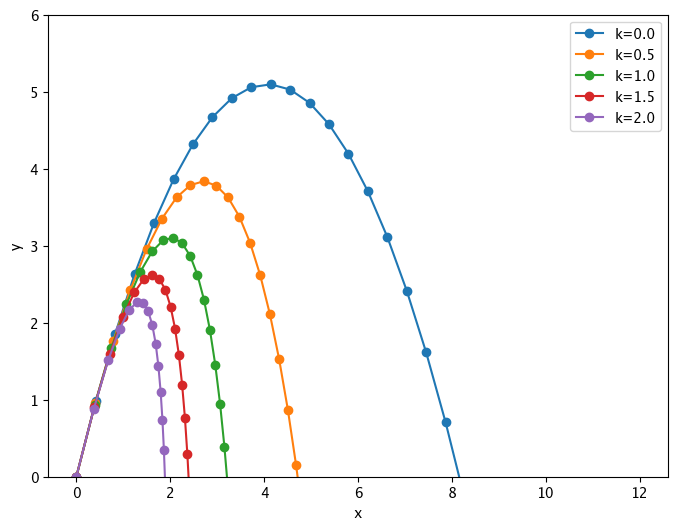

In [33]:
# define parameters
m = 1.  # particle's mass
k = 1.  # drag coefficient
g = 9.81  # gravity acceleration

# Define v0, a four-vector
v0 = np.zeros(4) # v0[0] and v0[1] are the initial positions and are set to zero

# Set the initial speed components x and y
v0[2] = 4.
v0[3] = 10.

# Define the time interval with linearly spaced times between t=0 and t=3
t = np.linspace(0., 3., 30)

# Define the function that takes the current vector v(t0) and a time t0 as arguments (with optional parameters)
# and that returns the derivative v'(t0):
def f(v, t0, k):
    # v has four components: v=[u, u'].
    u, udot = v[:2], v[2:]
    # compute the second derivative u'' of u.
    udotdot = -k / m * udot
    udotdot[1] -= g
    # return v'=(u', u'')
    return np.concatenate((udot, udotdot), axis=0) # row-wise merging

plt.figure(figsize=(8, 6))

# We simulate the system for different values of k
for k in np.arange(0., 2.5, 0.5):
    # evaluate v at a given time
    v = odeint(f, v0, t, args=(k,))
    # and plot the x and y positions (v components 0 and 1)
    plt.plot(v[:, 0], v[:, 1], 'o-', label="k=%.1f" % k)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0, 6])

## Fast Fourier Trasform

The [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) (FT) is a mathematical transform that decomposes functions that depend on space or time into functions depending on spatial or temporal frequency.

It is often used to **investigate features in the frequency space** and **filter the noise** from a periodic signal.

The `scipy.fftpack` module computes fast Fourier transforms (FFTs) and offers utilities to handle them. The main functions are:

* `scipy.fftpack.fft()` to compute the FFT
* `scipy.fftpack.fftfreq()` to generate the sampling frequencies
* `scipy.fftpack.ifft()` computes the inverse FFT, from frequency space to signal space

Let's see a practical example, generating a periodic signal (using a `np.sin` function) and adding on top some random noise:

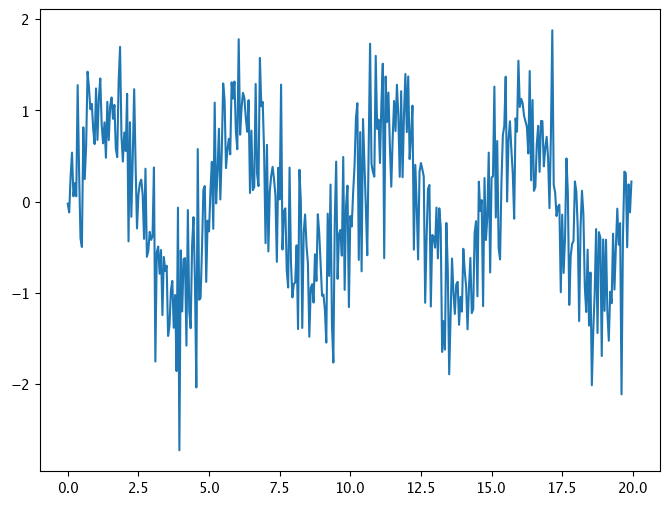

In [22]:
from scipy import fftpack

time_step = 0.05
ang_freq = 0.2
period = 1. / ang_freq
# define the time range
time_vec = np.arange(0, 20, time_step)
# define the function as signal + noise
sig = (np.sin(2 * np.pi / period * time_vec) + 0.5 * np.random.randn(time_vec.size))

plt.figure(figsize=(8, 6))
plt.plot(time_vec, sig, label='Original signal')

Let's now compute and plot the power spectrum using `fftpack.fft` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html)):

Peak frequency: 0.2
Does the peak correspond to the initial frequency? True


[]

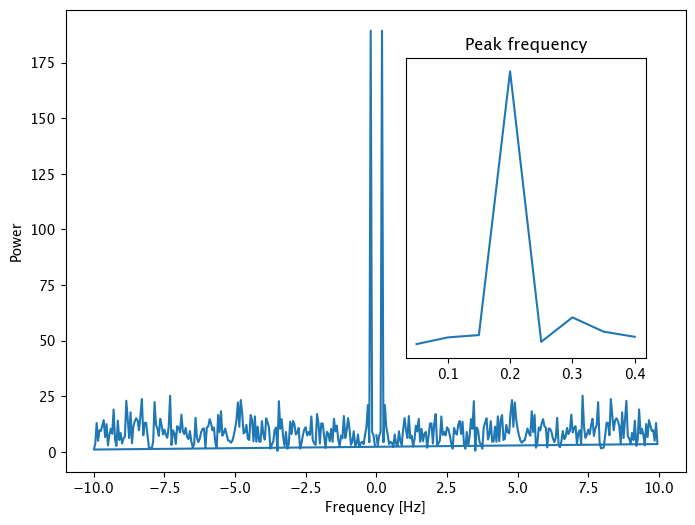

In [23]:
# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval

# The return the corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(8, 6))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')

# Find the peak frequency: focus only on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
powes = power[pos_mask]

# find the max of freqs array
peak_freq = freqs[powes.argmax()]
print("Peak frequency:", peak_freq)

# Check that it does indeed correspond to the frequency that we generate the signal with
print("Does the peak correspond to the initial frequency?", np.allclose(peak_freq, ang_freq))

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], powes[:8])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced peak detection

Now, we want to create a filter that removes the random noise and returns the periodic signal. We can observe that the random noise populates the high frequency part of the spectrum, so we may want to remove these:

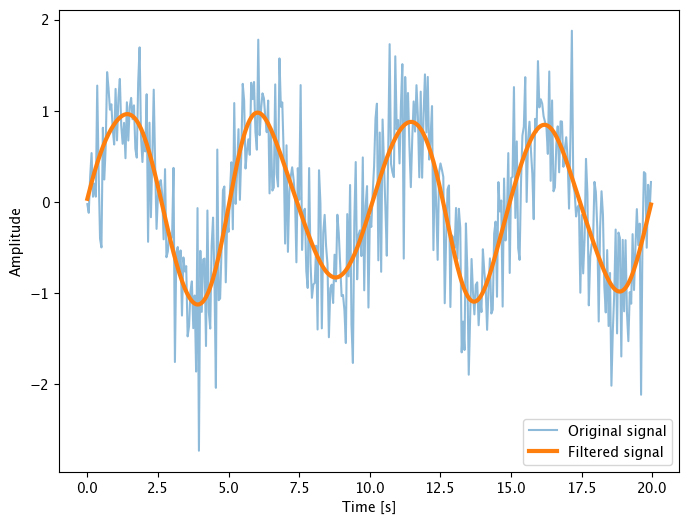

In [24]:
high_freq_fft = sig_fft.copy() # create an explicit copy of the FFT

# filter (set to zero) all high frequency components that are larger than peak_freq
high_freq_fft[np.abs(sample_freq) - peak_freq > 0.4] = 0

# calculate the Inverse Fast Fourier Transform
filtered_sig = fftpack.ifft(high_freq_fft)

# only take the real part
real_filtered_signal = np.real(filtered_sig)

# plot the result of the IFFT
plt.figure(figsize=(8, 6))
plt.plot(time_vec, sig, alpha=0.5, label='Original signal')
plt.plot(time_vec, real_filtered_signal, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

#### Example: Fourier transform of a real data file

We will apply this tool to weather data spanning 20 years obtained from the US National Climatic Data Center.

Each row of the `csv` data file contains the precipitation and extreme temperatures (minimum and maximum, and the unit is in tenths of a degree) recorded each day by one weather station in France.

In [26]:
!wget https://www.dropbox.com/s/tmminxpjxp9bqql/weather.csv -P ./data/

--2022-12-07 10:56:35--  https://www.dropbox.com/s/tmminxpjxp9bqql/weather.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tmminxpjxp9bqql/weather.csv [following]
--2022-12-07 10:56:35--  https://www.dropbox.com/s/raw/tmminxpjxp9bqql/weather.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaf008f78a4887048e076cc0651.dl.dropboxusercontent.com/cd/0/inline/ByLEDIiiXEmp3Z4dLtv20keQ5-P07pZ__KbnRlOTSHhtfzvErOipOTnRxoM5mdaehw1zm6rJoRetB2Asua-Vkvbp036fo3bir_zD5HtDjAmKSJ2G6GRekRDYjR9R4RUmAbc7wNPkAvJnJdkkW90Mz0cqoMTQl8mjx5DOc2ZxLowc5Q/file# [following]
--2022-12-07 10:56:36--  https://ucaf008f78a4887048e076cc0651.dl.dropboxusercontent.com/cd/0/inline/ByLEDIiiXEmp3Z4dLtv20keQ5-P07pZ__KbnRlOTSHhtfzvErOipOTnRxoM5mdaehw1zm6rJoRetB2Asua-Vkvbp036fo3bir_zD5HtDjAmKS

In [27]:
import pandas as pd
import datetime

df0 = pd.read_csv('./data/weather.csv', na_values=(-9999), parse_dates=['DATE'])
# clean up the data
df = df0[df0['DATE'] >= '19940101'].dropna()
df

,STATION,DATE,PRCP,TMAX,TMIN
365,GHCND:FR013055001,1994-01-01,0.0,104.0,72.0
366,GHCND:FR013055001,1994-01-02,4.0,128.0,49.0
367,GHCND:FR013055001,1994-01-03,0.0,160.0,87.0
368,GHCND:FR013055001,1994-01-04,0.0,118.0,83.0
369,GHCND:FR013055001,1994-01-05,34.0,133.0,55.0
...,...,...,...,...,...
300966,GHCND:FP000091925,2013-12-19,3.0,320.0,229.0
300970,GHCND:FP000091925,2013-12-24,180.0,296.0,226.0
300972,GHCND:FP000091925,2013-12-26,5.0,310.0,235.0
300975,GHCND:FP000091925,2013-12-29,0.0,311.0,226.0


For every date in the calendar, we want to get a single average temperature for the whole country. The `groupby()` method provided by Pandas lets us do this easily:

In [28]:
gdf = df.groupby('DATE').mean()
gdf

/var/folders/qz/qk6dlk4j0617p8dd29pkz4r80000gn/T/ipykernel_12651/1044365931.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf = df.groupby('DATE').mean()


,PRCP,TMAX,TMIN
DATE,,,
1994-01-01,178.666667,127.388889,70.333333
1994-01-02,122.000000,152.421053,81.736842
1994-01-03,277.333333,157.666667,95.555556
1994-01-04,177.105263,142.210526,95.684211
1994-01-05,117.944444,130.222222,75.444444
...,...,...,...
2013-12-28,40.500000,153.500000,78.333333
2013-12-29,22.000000,233.000000,154.666667
2013-12-30,5.555556,120.444444,50.777778


Text(0, 0.5, 'Mean temperature')

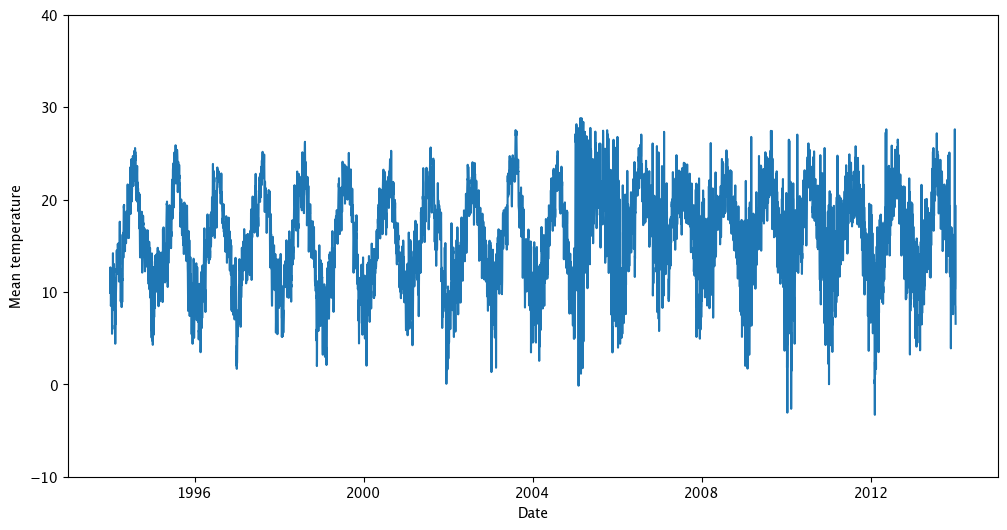

In [29]:
# calculate the average, by column, and convert to degrees
gdf['TAVG'] = (gdf['TMAX'] + gdf['TMIN']) / 20.

# get the Numpy arrays of time and temperature
date = gdf.index.to_numpy()
temp = gdf['TAVG'].to_numpy()

plt.figure(figsize=(12, 6))
plt.plot(date, temp)
plt.ylim(-10, 40)
plt.xlabel('Date')
plt.ylabel('Mean temperature')

In [30]:
# compute the Fourier transform and the spectral density of the signal
temp_fft = fftpack.fft(temp)

# take the square of its absolute value in order to get the power spectral density (PSD)
temp_psd = np.abs(temp_fft) ** 2

# get the frequencies
# we choose an annual unit: a frequency of 1 corresponds to 1 year (365 days)
fftfreq = fftpack.fftfreq(len(temp_psd), 1. / 365)

# consider only the real part of the signal (positive frequencies)
i = fftfreq > 0


plt.figure(figsize=(8, 6))
plt.plot(fftfreq[i], temp_psd[i])
#plt.ylim(0, 5)
plt.xlabel('Frequency (1/year)')
plt.ylabel('Power')
plt.yscale('log')

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.55, 0.3, 0.3])
plt.plot(fftfreq[:40], temp_psd[:40])
plt.setp(axes, yticks=[])
plt.yscale('log')

findfont: Font family ['DejaVu Sans'] not found. Falling back to DejaVu Sans.


Error in callback <function _draw_all_if_interactive at 0x10e9d5fc0> (for post_execute):


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

findfont: Font family ['DejaVu Sans'] not found. Falling back to DejaVu Sans.


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 800x600 with 2 Axes>

As we may expect, there is a peak in the power spectrum corresponding to a frequency of 1 year.